# Classification Based Approaches

# 1. KNN

We used KNN as an example as to why our agent should not use classification methods using state-action pairsto solve the issue. Initially, KNN needs all of its moves to be scaled into a determined set. Since there is so much different terrain, it is harder for it to adapt once a new unseen terrain is added or when an object moves to a new location relative to the frame.

Another issue for KNN is the curse of dimensionality. This dataset is composed of two numpy arrays: a 3D array that describes the environment and a 1D array that describes the action taken. In many cases in training, our players did drastically different actions at the same observation or the same action at a slightly different observation. Therefore, KNN has difficulties in finding similarities between records. This resulted in our KNN model taking vast amounts of time for training off of a singular isloated run and thus not finishing. 

# 2. Decision Trees
We also used a decision tree to further demonstrate how classification using state-action pairs was inappropriate for our problem. Our data is filled with many occurrences of the same observation but slightly different actions in reaction to the same environment. 
In one run, the same person could jump at a frame earlier and thus not jump at the consequent frame or the same person could jump
at the consequent frame and not do anything in the frame prior. This makes it difficult for the agent to draw similarities
between runs, making it hard for the tree to fit an action to a specific state. 

# 3. ADABoosting
We used ADABoosting as an example as to why our agent should not use classification methods using state-action pairs to play super mario. Though the accuracy of the boosting model is generally higher than techniques alone, in our case, since we are using ensembling in a supervised learning way based on the decision tree stump model, the ensemble booster model accuracy is ____. Since the goal of our classification is to classify in a way that allows the model to beat the super mario game, the application of ensembling wouldn't be the best as it would base the action it takes strictly on the states ran through by a mario play-through done by the user, which could be susceptible to faulty playthroughs. If we were to apply an RL agent on the other hand which creates policies on the premise of maximizing rewards as our model for ADABoosting, it would likely be a good approach as the accuracy would be increased substantially.

# 4. CNN

Process: Our process involved splitting the dataset into training and validation sets using a 80-20 ratio. We tested every combination of kernel size and activation function for 4 epochs. Once we decided not to vary our batch size we kept it constant at 32. We then recorded the training histories which included the training and validation accuracies for each combination of hyperparameters.

Conclusion: Based on hyperparameter tuning we found that the combination of a kernel size with (3,3) and the tanh activation function seemed to be the most effective as evidenced by the training and validation accuracy.

Further steps: In order to further tune our hyperparameters to make more accurate predictions we could vary the number of our convolutional layers. Since increasing the number of convolutional layers may allow our model to distinguish between more complex representations, we may be able to improve our performance. We could also test different learning rates to optimize convergence.




In [ ]:
import gym_super_mario_bros
import gym
import nes_py
from nes_py.wrappers import JoypadSpace
from nes_py.app.play_human import play_human
from gym.wrappers.gray_scale_observation import GrayScaleObservation
import cv2
import numpy as np
import sys
from datetime import datetime
import argparse
import pickle
from playback import get_state_action_pairs 
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split 

The below code converts our game space from rgb to grayscale. Eliminate unecessary action remaps our actionspace from 0->7 as this is what our action input data is looking for. Each number responds to a specific action such as 128 occurs when the user click d and it causes Mario to move forward.

In [ ]:

def rgb2gray(rgb):
    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
    return gray

def eliminate_unnecessary_action(data):
    action_space = data
    action_map = {
        64: 0,
        65: 1,
        66: 2,
        67: 3,
        128: 4,
        129: 5,
        130: 6,
        131: 7
    }
    
    action_space = np.array([action_map.get(action, 0) for action in action_space])
    return action_space

The code below defines a specific CNN architecture. It is using TensorFlow's keras library.

In [ ]:
# Create CNN model with specific layers, some values given from CNN tutorial with tensorflow
def create_cnn(input_shape, num_classes):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

Kernel Sizes: We tested three different kernel sizes ((3,3),(5,5),(7,7)). As a smaller kernel sizes focus on smaller regions of our input image, we expected the larger kernel sizes to be more effective as they would capture a wider range of information from our input image.

Activation Functions: We tested three different activation functions (Rectified Linear Unit, Hyperbolic Tangent, and Sigmoid).
As relu (Rectified Linear Unit), is known for its effectiveness with regards to deep learning models, we expected it to perform the best.

Note: Tried batch sizes but didn't feel it had a significant enough change in our accuracy. Now we set our batch size to 32.

In [ ]:
def hyperparameter_tuning(state_history, action_history):
    kernel_sizes = [(3, 3), (5, 5),(7,7)]
    activation_functions = ['relu','tanh','sigmoid']
    #batch_sizes = [32, 64, 128]

    training_histories = []
    accuracies = []

    for kernel_size in kernel_sizes:
        for activation_function in activation_functions:
            print(f"training with kernel size: {kernel_size} and activation function: {activation_function}")
            train_a, test_a, train_b, test_b = train_test_split(state_history, action_history, test_size=0.2, random_state=42)
            train_a = np.expand_dims(train_a, axis=-1)
            test_a = np.expand_dims(test_a, axis=-1)
            
            train_a = train_a / 255.0
            test_a = test_a / 255.0

            model = create_cnn(input_shape=(state_history.shape[1], state_history.shape[2], 1), num_classes=np.max(action_history) + 1)
            model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

            history = model.fit(train_a, train_b, epochs=4, batch_size=32, validation_data=(test_a, test_b))

            training_histories.append(history)
            accuracies.append(history.history['val_accuracy'][-1])

The code below graphs both the training accuracy and the validation accuracy over a specified amount of epochs. The graph line colors correspond to the specific combination of kernel sizes and and activation functions. The same combination color is used for the training accuracy and the validation accuracy.

In [ ]:
    plt.figure(figsize=(10, 12))
    colors = plt.cm.tab10.colors[:len(kernel_sizes) * len(activation_functions)]

    plt.subplot(2, 1, 1)
    for i, kernel_size in enumerate(kernel_sizes):
        for j, activation_function in enumerate(activation_functions):
            plt.plot(range(1, 5), training_histories[i*len(activation_functions)+j].history['accuracy'], label=f'kernel size:{kernel_size}, activation:{activation_function}')

    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Training Accuracy')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15),ncol=3,fontsize='small')

    plt.subplot(2, 1, 2)
    for i, kernel_size in enumerate(kernel_sizes):
        for j, activation_function in enumerate(activation_functions):
            color = colors[i*len(activation_functions)+j
            plt.plot(range(1, 5), training_histories[i*len(activation_functions)+j].history['val_accuracy'], label=f'kernel size: {kernel_size}, activation:{activation_function}', color=color)

    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('validation accuracy')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=3, fontsize='small')

    plt.tight_layout()
    plt.show()

    print("Validation Accuracies:")
    for i, kernel_size in enumerate(kernel_sizes):
        for j, activation_function in enumerate(activation_functions):
            print(f'kernel size:{kernel_size}, activation:{activation_function}: {accuracies[i*len(activation_functions)+j]}')


Define the CNN Agent.

In [ ]:
class CNNAgent:
    def __init__(self, model=None, state_history=None, action_history=None):
        self.done = False
        self.name = "cnn_agent"
        if model is None:
            num_classes = np.max(action_history) + 1
            self.model = create_cnn(input_shape=(state_history.shape[1], state_history.shape[2], 1), num_classes=num_classes)
        else:
            self.model = model

    def get_action(self, state):
        state = np.expand_dims(state, axis=0)
        state = np.expand_dims(state, axis=-1)
        return np.argmax(self.model.predict(state))
        
    def train(self, state_history, action_history):

        print("Training...")
        train_a, test_a, train_b, test_b = train_test_split(state_history, action_history, test_size=0.2, random_state=42)
        train_a = np.expand_dims(train_a, axis=-1)
        test_a = np.expand_dims(test_a, axis=-1)
        train_a = train_a / 255.0
        test_a = test_a / 255.0
        self.model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        history = self.model.fit(train_a, train_b, epochs=1, validation_data=(test_a, test_b))
        self.model.save("models/cnn_model.h5")
        print("Training complete.")

        #Graph validation and training accuracy as epochs increase
        plt.plot(history.history['accuracy'], label='accuracy')
        plt.plot(history.history['val_accuracy'], label='val_accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend(loc='lower right')
        plt.show()
        pass


In [ ]:
def run_agent(agent):

    env = GrayScaleObservation(gym_super_mario_bros.make("SuperMarioBros-v3"))
    env.reset()

    action_history = []
    state_history = []
    reward_history = []

    action = [0]
    done = False
    while not done:
        state, reward, done, _ = env.step(action)
        action_history.append(action)
        state_history.append(rgb2gray(state))
        reward_history.append(reward)
        action = agent.get_action(state)
        if done:
            print("Done")
            break
        if agent.done:
            print("Agent done")
            done = True
            break

    day_time = datetime.today().strftime("%m%d%y_%H%M%S")
    np.savez(f".\\agent_recordings\\{agent.name}_{day_time}", np.array(state_history), np.array(action_history), np.array(reward_history))
    print("Recording saved")
    env.close()
    cv2.destroyAllWindows()
    print("Windows closed")


In [ ]:

rec_state_history, rec_action_history = get_state_action_pairs(2)
rec_action_history = eliminate_unnecessary_action(rec_action_history)
agent = CNNAgent(model=None, state_history=rec_state_history, action_history=rec_action_history)
hyperparameter_tuning(rec_state_history, rec_action_history)

# 4. Proximal Policy Optimization using Stable Baselines 3
After finding that most classification approaches failed to yield useful results, we decided to consult the literature for a more appropriate approach. Promimal Policy Optimization (https://arxiv.org/pdf/1707.06347.pdf) is a reinforcement learning approach developed by OpenAI in 2017. Since then it has become a standard approach for reinforcement learning tasks. After doing some research online, we were able to find a utility wrapper for the SuperMarioBros gym environment. This wrapper accesses the RAM of the NES simulator directly, exposing the location of Mario and the scene features directly. This makes it easier for PPO to learn a performant policy more quickly as it doesn't need to learn the mapping from the image space to semanticly meaningful features.



In [1]:
# All necessary imports
from nes_py.wrappers import JoypadSpace
import gym 
import gym_super_mario_bros
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT, RIGHT_ONLY 

from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv, VecEnv, SubprocVecEnv
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.callbacks import BaseCallback
import os
import time
import matplotlib.pyplot as plt
from datetime import datetime
from gym_utils import SMBRamWrapper
from stable_baselines3.common.evaluation import evaluate_policy
import matplotlib.pyplot as plt

%matplotlib inline

### Defining Callback and Helper Functions
The logging callback class is used to populate the score/time_step lists for later display.  
The linear schedule is derived from the stablebaselines documentation, and is considered a standard approach for PPO.

In [2]:
class EvaluationCallback(BaseCallback):

    def __init__(self, check_freq, env_wrap, starting_steps=0, verbose=1):
        super(EvaluationCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.starting_steps = starting_steps
        self.evaluations = []

    def _init_callback(self):
        self.env_wrap = self.model.get_env()
        print("Initialized Callback")

    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            eval = evaluate_policy(self.model, self.env_wrap, n_eval_episodes=1, deterministic=True, render=False, return_episode_rewards=False)
            self.evaluations.append(eval[0])
        return True
    
# Linear learning rate schedule
# https://stable-baselines3.readthedocs.io/en/master/guide/examples.html#learning-rate-schedule
from typing import Callable

def linear_schedule(initial_value: float) -> Callable[[float], float]:
    """
    Linear learning rate schedule.

    :param initial_value: Initial learning rate.
    :return: schedule that computes
      current learning rate depending on remaining progress
    """
    def func(progress_remaining: float) -> float:
        """
        Progress will decrease from 1 (beginning) to 0.

        :param progress_remaining:
        :return: current learning rate
        """
        return progress_remaining * initial_value

    return func

In [3]:
# Create the environment
env = gym_super_mario_bros.make('SuperMarioBros-1-1-v3')
env = JoypadSpace(env, SIMPLE_MOVEMENT)
x0 = 0
x1 = 16
y0 = 0
y1 = 13
n_stack = 4
n_skip = 4
env_wrap = SMBRamWrapper(env, [x0, x1, y0, y1], n_stack=n_stack, n_skip=n_skip)
env_wrap = Monitor(env_wrap)
env_wrap = DummyVecEnv([lambda: env_wrap])


In [4]:
day_time = datetime.today().strftime("%m%d%y_%H%M%S")
MODEL_DIR = './models/PPO_' + day_time
# LOG_DIR = './logs/'

In [5]:
model = PPO('MlpPolicy', env_wrap, verbose=0, learning_rate=linear_schedule(3e-4)) 

In [6]:
callback = EvaluationCallback(check_freq=250, starting_steps=0)

In [7]:
#Training the model
t_start = time.time()
model.learn(total_timesteps=3*10e3, callback=callback,progress_bar=True)
t_elapsed = time.time() - t_start
print('Wall time: {} s'.format(round(t_elapsed, 2)))
# Save model
model_path = os.path.join(MODEL_DIR)
model.save(model_path)

Initialized Callback


c:\Users\lucam\miniconda3\envs\yumouwei\lib\site-packages\gym_super_mario_bros\smb_env.py:148: RuntimeWarning: overflow encountered in scalar subtract
  return (self.ram[0x86] - self.ram[0x071c]) % 256


Wall time: 3813.31 s


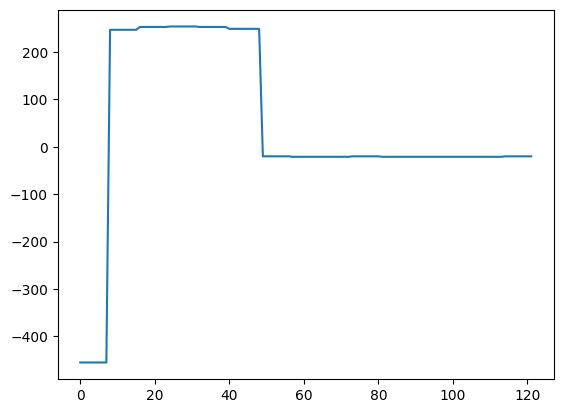

In [8]:
# evaluate the model
evaluate_policy(model, env_wrap, n_eval_episodes=1, deterministic=True, render=False, return_episode_rewards=False)
plt.figure()
plt.plot(callback.evaluations)
plt.show()

In [9]:
episode = 1

for episode in range(1, episode+1):
    states = env_wrap.reset()
    done = False
    score = 0
    
    while not done:
        env_wrap.render()
        action, _ = model.predict(states, deterministic=True)
        states, reward, done, info = env_wrap.step(action)
        score += reward
        time.sleep(0.01)
    print('Episode:{} Score:{}'.format(episode, score))

c:\Users\lucam\miniconda3\envs\yumouwei\lib\site-packages\pyglet\image\codecs\wic.py:289: UserWarning: [WinError -2147417850] Cannot change thread mode after it is set
  warnings.warn(str(err))


KeyboardInterrupt: 

In [10]:
env.close()

In [11]:
callback.evaluations

[-455.0,
 -455.0,
 -455.0,
 -455.0,
 -455.0,
 -455.0,
 -455.0,
 -455.0,
 247.0,
 247.0,
 247.0,
 247.0,
 247.0,
 247.0,
 247.0,
 247.0,
 253.0,
 253.0,
 253.0,
 253.0,
 253.0,
 253.0,
 253.0,
 253.0,
 254.0,
 254.0,
 254.0,
 254.0,
 254.0,
 254.0,
 254.0,
 254.0,
 253.0,
 253.0,
 253.0,
 253.0,
 253.0,
 253.0,
 253.0,
 253.0,
 249.0,
 249.0,
 249.0,
 249.0,
 249.0,
 249.0,
 249.0,
 249.0,
 249.0,
 -20.0,
 -20.0,
 -20.0,
 -20.0,
 -20.0,
 -20.0,
 -20.0,
 -20.0,
 -21.0,
 -21.0,
 -21.0,
 -21.0,
 -21.0,
 -21.0,
 -21.0,
 -21.0,
 -21.0,
 -21.0,
 -21.0,
 -21.0,
 -21.0,
 -21.0,
 -21.0,
 -21.0,
 -20.0,
 -20.0,
 -20.0,
 -20.0,
 -20.0,
 -20.0,
 -20.0,
 -20.0,
 -21.0,
 -21.0,
 -21.0,
 -21.0,
 -21.0,
 -21.0,
 -21.0,
 -21.0,
 -21.0,
 -21.0,
 -21.0,
 -21.0,
 -21.0,
 -21.0,
 -21.0,
 -21.0,
 -21.0,
 -21.0,
 -21.0,
 -21.0,
 -21.0,
 -21.0,
 -21.0,
 -21.0,
 -21.0,
 -21.0,
 -21.0,
 -21.0,
 -21.0,
 -21.0,
 -21.0,
 -21.0,
 -21.0,
 -20.0,
 -20.0,
 -20.0,
 -20.0,
 -20.0,
 -20.0,
 -20.0,
 -20.0]